Saving PRICE_AND_DEMAND_201801_NSW1.csv to PRICE_AND_DEMAND_201801_NSW1.csv


<ipython-input-1-c7e6e3579010>:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = df[['TOTALDEMAND', 'RRP']].resample('H').mean().dropna()


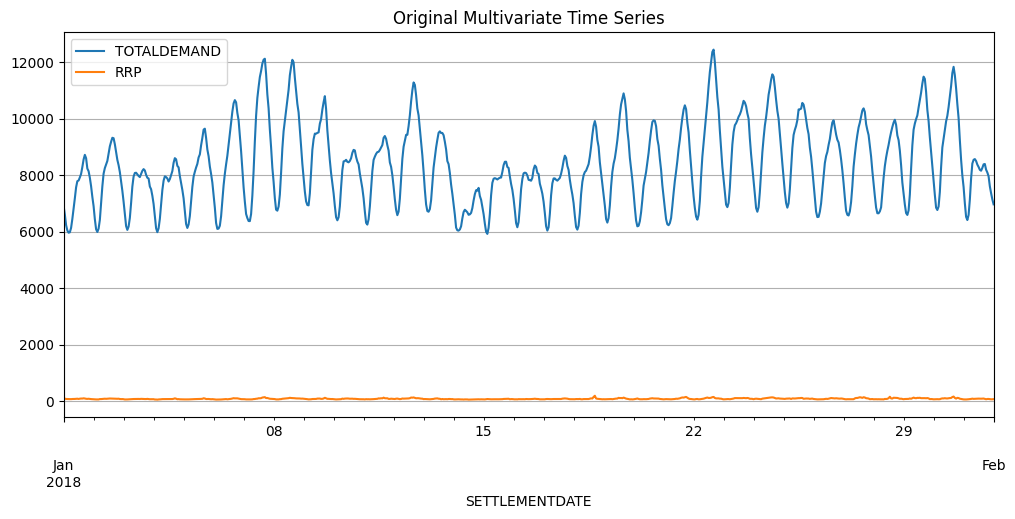

Optimal lag order:  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        16.05       16.07   9.348e+06       16.06
1        14.56       14.60   2.097e+06       14.57
2        14.33       14.40   1.667e+06       14.36
3        14.25       14.36   1.550e+06       14.30
4        14.25       14.39   1.538e+06       14.30
5        14.23       14.40   1.520e+06       14.30
6        14.23       14.43   1.509e+06       14.31
7        14.21       14.44   1.478e+06       14.30
8        14.07       14.34   1.294e+06       14.18
9        14.00       14.30   1.206e+06       14.12
10       13.97       14.29   1.164e+06       14.09
11       13.91      14.27*   1.102e+06       14.05
12       13.89       14.28   1.079e+06       14.04
13       13.89       14.31   1.081e+06       14.06
14       13.87       14.32   1.060e+06       14.05
15      13.85*       14.33  1.035e+06*      14.04*
------------

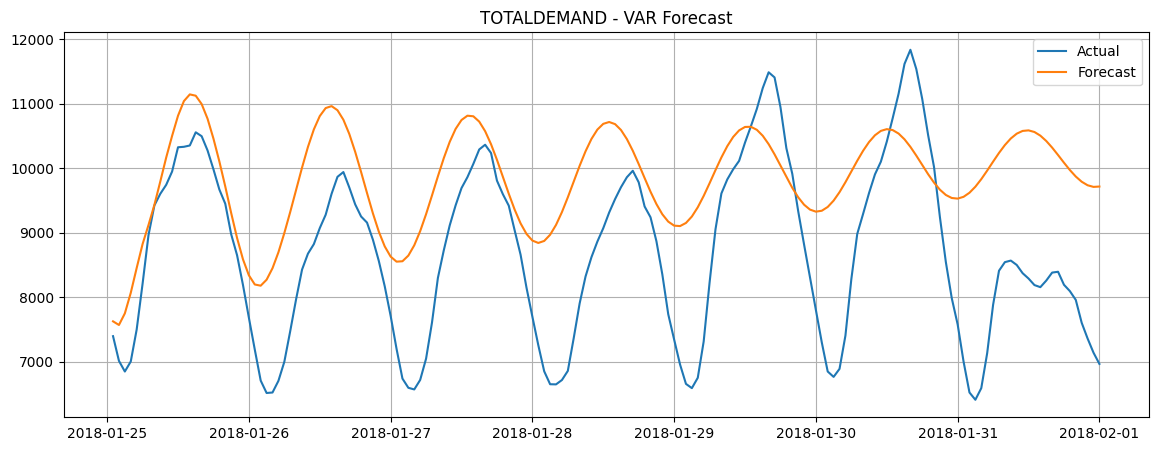

MSE: 2321530.71


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from google.colab import files
import io

# Upload file
uploaded = files.upload()
for fn in uploaded.keys():
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

# Parse datetime and filter columns
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df.set_index('SETTLEMENTDATE', inplace=True)

# Use multivariate time series: TOTALDEMAND and RRP (you can add more)
data = df[['TOTALDEMAND', 'RRP']].resample('H').mean().dropna()

# Plot original data
data.plot(title="Original Multivariate Time Series", figsize=(12, 5))
plt.grid(True)
plt.show()

# Difference to make stationary (VAR needs stationarity)
data_diff = data.diff().dropna()

# Split into train and test
n_obs = 24 * 7  # last week for test
train, test = data_diff[:-n_obs], data_diff[-n_obs:]

# Fit VAR model
model = VAR(train)
lag_order = model.select_order(maxlags=15)
print("Optimal lag order:", lag_order.summary())

model_fitted = model.fit(lag_order.aic)

# Forecast
forecast_input = train.values[-model_fitted.k_ar:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_obs)

# Convert forecast to dataframe
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

# Reverse differencing
forecast_values = forecast_df.cumsum() + data.iloc[-n_obs - 1]

# Plot actual vs forecast
plt.figure(figsize=(14, 5))
plt.plot(data['TOTALDEMAND'].iloc[-n_obs:], label='Actual')
plt.plot(forecast_values['TOTALDEMAND'], label='Forecast')
plt.title("TOTALDEMAND - VAR Forecast")
plt.legend()
plt.grid(True)
plt.show()

# Forecast evaluation
mse = mean_squared_error(data['TOTALDEMAND'].iloc[-n_obs:], forecast_values['TOTALDEMAND'])
print(f'MSE: {mse:.2f}')
